In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl 
from IPython.display import display

In [1]:


survey_set = "combined"
if survey_set == "ios":
    df = pd.read_csv('../Results/ios_results-survey317138.csv', delimiter=';')
elif survey_set == "android":
    df = pd.read_csv('../Results/results-survey117478.csv')
elif survey_set == "combined":
    df_ios = pd.read_csv('../Results/ios_results-survey317138.csv', delimiter=';')
    # Adapt response ID to make sure it is unique
    df_ios['Response ID'] = df_ios['Response ID'] + 1000000
    df_ios.index = df_ios.index + 1000000
    df_android = pd.read_csv('../Results/results-survey117478.csv')
    # Combine both dataframes 
    df = pd.concat([df_ios, df_android])

# Filter out all unfinished responses 
df_unfinished = df[df['Date submitted'].isna()]
df_finished = df[df["Date submitted"].isna() == False]

# Remove people who have not agreed to data protection
df_finished = df_finished[df_finished.iloc[:, 8] == 'Yes']

df_map_idx_response_id = pd.DataFrame(columns=['Response ID', 'idx'])
df_map_idx_response_id['Response ID'] = df_finished['Response ID']
df_map_idx_response_id['idx'] = df_finished.index
df_map_idx_response_id.to_csv(f'../Results/idx_response_id_map_{survey_set}.csv')

# Remove people who did not provide adequate answers in open questions 
idx_to_remove_android = {17312, 2371, 5126, 2666, 10926, 944, 4080, 8626, 5366, 1001058}
print(f"Removed answers {len(idx_to_remove_android)}")
df_finished = df_finished[~df_finished.index.isin(idx_to_remove_android)]

# Compare unfinished and finished surveys

# display(df_unfinished.shape)
# display(df_finished.shape)

# Calculate stats of respondents 
print(f"Finished respondents: {df_finished.shape[0]}")
print(f"Unfinished respondents: {df_unfinished.shape[0]}")

android_users = (df_finished["How did you find out about our survey?"] == "AirGuardAppAndroid").value_counts()[True]
ios_users = (df_finished["How did you find out about our survey?"] == "AirGuardAppiOS").value_counts()[True]
others = len(df_finished) - android_users - ios_users
print(f"Android respondents: {android_users}")
print(f"IOS respondents: {ios_users}")
print(f"Other respondents: {others}")

# Number of stalking victims 
stalking_victims = (df_finished["Have you been a victim to stalking in general?\u00a0"] == "Yes").value_counts()[True]
df_stalking_victims = df_finished[df_finished["Have you been a victim to stalking in general?\u00a0"] == "Yes"]
print(f"Stalking victims: {stalking_victims}")

df_no_stalking_victims = df_finished[df_finished["Have you been a victim to stalking in general?\u00a0"] == "No"]

Removed answers 10
Finished respondents: 5253
Unfinished respondents: 15438
Android respondents: 4781
IOS respondents: 411
Other respondents: 61
Stalking victims: 1005


# iOS 
1165 unfinished 
413 finished 

# Android 
14273 unfinished
4841 finished

# Total
20,692 started 
15,438 unfinished
5,254 finished 


In [2]:
# Each row represents a reply to the survey. Many columns represents a question of the survey. Each entry in a colum is the reply to the question.
# The first columns are the metadata of the survey. The last columns are the questions of the survey.

# Increase the number of lines shown in the output 
pd.options.display.max_rows = 40000
pd.options.display.max_seq_items = 40000

# Print all columns of the dataframe
column_list = df.columns.to_list()
column_question_list = column_list[9:]

total_time_index = column_question_list.index('Total time')
column_question_list = column_question_list[:total_time_index]

# Print all the questions of the survey 
print(column_question_list)

['Minimum age declaration  [I hereby state that I am at least 16 years old]', 'Which potential misuse of key finders / Bluetooth trackers (e.g. AirTags) has been known to you before you started this survey? [Stalking]', 'Which potential misuse of key finders / Bluetooth trackers (e.g. AirTags) has been known to you before you started this survey? [Car theft (tracking a valuable car to its parking location)]', 'Which potential misuse of key finders / Bluetooth trackers (e.g. AirTags) has been known to you before you started this survey? [Espionage]', 'Which potential misuse of key finders / Bluetooth trackers (e.g. AirTags) has been known to you before you started this survey? [Absence tracking (detecting when someone is not at home)]', 'Which potential misuse of key finders / Bluetooth trackers (e.g. AirTags) has been known to you before you started this survey? [Other]', 'Do you agree with the statement:  "During the next 12 months, somebody will try to track me using a key finder" ',

In [3]:
# Get multiple choice questions
import re

questions_no_anwers = [] # All questions
multiple_choice_questions = {} # Dict with {question: [answer]}
single_choice_questions = {} # Dict with {question: [answer]}
open_answers = [] # Array of questions
for question in column_question_list:
    # Use regex to find the questions with multiple choice answers. regex: ".*\[.*\]$"

    if re.match(".*\[.*\]$", question):
        # Answers are marked in square brackets. Remove the part with the answers from the question
        # Get each answer from the question and add it to the list of answers
        answer = re.findall("\[.*\]$", question)[0]
        answer = answer.replace("[", "")
        answer = answer.replace("]", "")

        question = re.sub("\[.*\]$", "", question)
        # Trim whitespace on the left and right side of the question
        question = question.strip()

        if question in multiple_choice_questions:
            multiple_choice_questions[question].append(answer)
        else:
            multiple_choice_questions[question] = [answer]

        if question not in questions_no_anwers:
            questions_no_anwers.append(question)
    else:
        if question not in questions_no_anwers:
            single_choice_questions[question] = [] 
            questions_no_anwers.append(question)


# Print the multiple choice questions
print(multiple_choice_questions)
print(questions_no_anwers)


{'Minimum age declaration': ['I hereby state that I am at least 16 years old'], 'Which potential misuse of key finders / Bluetooth trackers (e.g. AirTags) has been known to you before you started this survey?': ['Stalking', 'Car theft (tracking a valuable car to its parking location)', 'Espionage', 'Absence tracking (detecting when someone is not at home)', 'Other'], 'Which potential actors do concern you in the case of location tracking?': ['My employer', 'Friends', 'Government agencies', 'Companies', '(Former) intimate partners', 'Other'], 'Has your location been tracked without by any of these tracking devices?': ['Apple Tracker (AirTag or other Find My Tracker)', 'Samsung SmartTag', 'Google Tracker (available late summer 2023)', 'Tile', 'Chipolo', 'General GPS Tracker', 'No', 'Other'], 'Which gender did your stalker have?': ['Other'], 'What do you think has been the motivation of the stalker?': ['Desire for a loving relationship', 'Resumption of a former relationship', 'Jealousy, e

In [4]:
# Filter the dataframe to contain only the questions columns 
df_questions = df_finished[column_question_list]

# Print the first 5 rows of the dataframe
df_questions.head()

# Save all questions to a CSV 
df_questions.to_csv(f'../Results/results_questions_only_{survey_set}.csv')

In [5]:
# Define the questions for which we can use simple percentages 
print(questions_no_anwers)

all_questions = [
    'Minimum age declaration',
    'Which potential misuse of key finders / Bluetooth trackers (e.g. AirTags) has been known to you before you started this survey?',
    'Do you agree with the statement:  "During the next 12 months, somebody will try to track me using a key finder" ',
    'Which potential actors do concern you in the case of location tracking?',
    'Do you think the easy accessibility of Apple AirTags, Tile trackers and Samsung Smart Tags has led to more stalking?\xa0',
    'Do you think there is need for a government regulation that disallows the misuse of key finders such that they can be used for stalking?  E.g. forbid tracking of moving targets, delay location updates by several hours ',
    'Is the intended function of these devices (finding lost items) more important to you than the potential misuse of them? ',
    'Have you been a victim to stalking in general?\xa0',
    'Which gender did your stalker have?', 'How long did the stalking continue?',
    'How often have you been pursued?',
    'Have you been a victim to ongoing harassment?',
    'How is your current relation to the stalker?',
    'What do you think has been the motivation of the stalker?',
    'What methods of stalking have been used?',
    'How has stalking impacted your life?',
    'Anti-tracking solutions in a Smartphone or based on an app ... ',
    'How do you think stalking protection can be enhanced?', 
    'Are you a user of AirGuard or have you used AirGuard in the past?   \xa0  ',
    'Since I discovered AirGuard I feel ...',
    'How would you rate the onboarding of the app?That is the first view you see when opening the app and where you need to permit Bluetooth, Location, and Battery scheduling.',
    'Which version of the dashboard do you prefer?\xa0  \xa0\xa0\xa0 ',
    'Chose the statement that fits best concerning the discovery of\xa0key finders\xa0and other\xa0trackers\xa0in AirGuard ',
    'Which behaviour of AirGuard would you prefer?  An\xa0alert\xa0is a notification sent by AirGuard that informs you that a potential tracking device has followed you.\xa0 ',
    'Did you receive a notification from AirGuard for a tracker / key finder that has been used to stalk you? ', 'Where was the tracking device located?',
    'Did you experience incorrect/false notifications from AirGuard and when did they occur?In this case the Bluetooth Tracker close to you was not used to actually track your location.',
    'Do many incorrect notifications make you feel unsafe or anxious?Please explain your experience with incorrect notifications below. Like all questions, this is an optional question.',
    'Do you think the current methods in AirGuard to find a tracker are helpful?  The first screenshot shows the notification that you receive from AirGuard when it detects a potential tracker.The second one shows the screen that you get when you tap on the notification. It shows a map with locations at which the tracker has been seen. Also it offers buttons to interact with certain trackers. For AirTags you can start playing a sound on them to find them.\xa0   ',
    'What are you missing in AirGuard?',
    'Please select your gender.\xa0',
    'Please select your gender.',
    'Please select the age group that matches your age. ',
    'Please select in which region you are located',
    'How did you find out about our survey?']

['Minimum age declaration', 'Which potential misuse of key finders / Bluetooth trackers (e.g. AirTags) has been known to you before you started this survey?', 'Do you agree with the statement:  "During the next 12 months, somebody will try to track me using a key finder" ', 'Which potential actors do concern you in the case of location tracking?', 'Do you think the easy accessibility of Apple AirTags, Tile trackers and Samsung Smart Tags has led to more stalking?\xa0', 'Do you think there is need for a government regulation that disallows the misuse of key finders such that they can be used for stalking?  E.g. forbid tracking of moving targets, delay location updates by several hours ', 'Is the intended function of these devices (finding lost items) more important to you than the potential misuse of them? ', 'Has your location been tracked without by any of these tracking devices?', 'Have you been a victim to stalking in general?\xa0', 'Which gender did your stalker have?', 'How long d

In [6]:
df_questions.head()

,Minimum age declaration [I hereby state that I am at least 16 years old],Which potential misuse of key finders / Bluetooth trackers (e.g. AirTags) has been known to you before you started this survey? [Stalking],Which potential misuse of key finders / Bluetooth trackers (e.g. AirTags) has been known to you before you started this survey? [Car theft (tracking a valuable car to its parking location)],Which potential misuse of key finders / Bluetooth trackers (e.g. AirTags) has been known to you before you started this survey? [Espionage],Which potential misuse of key finders / Bluetooth trackers (e.g. AirTags) has been known to you before you started this survey? [Absence tracking (detecting when someone is not at home)],Which potential misuse of key finders / Bluetooth trackers (e.g. AirTags) has been known to you before you started this survey? [Other],"Do you agree with the statement: ""During the next 12 months, somebody will try to track me using a key finder""",Which potential actors do concern you in the case of location tracking? [My employer],Which potential actors do concern you in the case of location tracking? [Friends],Which potential actors do concern you in the case of location tracking? [Government agencies],...,"Did you experience incorrect/false notifications from AirGuard and when did they occur?In this case the Bluetooth Tracker close to you was not used to actually track your location. [When I was commuting in public transport (Train, Airplane, etc.)]",Did you experience incorrect/false notifications from AirGuard and when did they occur?In this case the Bluetooth Tracker close to you was not used to actually track your location. [Other],"Do many incorrect notifications make you feel unsafe or anxious?Please explain your experience with incorrect notifications below. Like all questions, this is an optional question.",Do you think the current methods in AirGuard to find a tracker are sufficient? \tAirGuard sends a notification if a tracker follows you \tYou can scan for nearby trackers \tYou can locate trackers based on a scale from 0-100% \tYou can let AirGuard observe trackers for one hour and get a notification if the tracker is still nearby,What are you missing in AirGuard?,Please select your gender.,Please select your gender. [Other],Please select the age group that matches your age.,Please select in which region you are located,How did you find out about our survey?
1000028,Yes,Yes,Yes,No,Yes,NaN,strongly disagree,No,No,No,...,No,Hotel,NaN,Yes,NaN,Male,NaN,26-35,Western Europe,AirGuardAppiOS
1000037,Yes,Yes,Yes,Yes,Yes,NaN,strongly agree,No,No,No,...,NaN,NaN,NaN,NaN,NaN,Female,NaN,36-45,Western Europe,AirGuardAppiOS
1000053,Yes,Yes,Yes,No,Yes,NaN,strongly disagree,No,Yes,No,...,No,NaN,NaN,Yes,NaN,Male,NaN,36-45,Western Europe,AirGuardAppiOS
1000054,Yes,Yes,No,No,No,NaN,disagree,No,No,No,...,No,NaN,NaN,Yes,NaN,Male,NaN,26-35,Northern Europe,AirGuardAppiOS
1000055,Yes,Yes,Yes,Yes,Yes,NaN,disagree,Yes,No,Yes,...,No,NaN,NaN,Yes,NaN,Male,NaN,26-35,Western Europe,AirGuardAppiOS


In [7]:
# Iterate over all questions and answers and calculate percentage

multiple_choice_answers = {}

results = {} # Dict with {question: {answer: count}}

for question in questions_no_anwers: 
    # Get all columns that contain an answer 
    answer_columns = df_questions.columns[df_questions.columns.str.startswith(question)]
    # print(f"Question: {question}")
    # print(answer_columns)

    # Check how often each answer was selected 
    answer_counts = {}

    for answer_column in answer_columns:
        # answer for the current answer_column. The answer is part of the column name
        # If we can find the answer in the column name it's a multple choice question.
        
        answer = answer_column.replace(question, "")
        answer = answer.replace("[", "")
        answer = answer.replace("]", "") 
        answer = answer.strip()

        other_replies = None
        open_ended_answers = None 

        if len(answer) > 0:
            if answer.lower() != "other":
                # Count how often
                answer_counts[answer] = (df_questions[answer_column] == "Yes").sum()
            else:
                # Other is a special case. Count how often the question was answered
                answer_counts[answer] = (df_questions[answer_column].isna() == False).sum()
                # Save the replies to the question by getting all rows where the answer is not empty. Format it to a list 
                other_replies = df_questions[df_questions[answer_column].isna() == False][answer_column].to_list()
                # Check if othr replies are only "Yes"
                only_yes_reply = True
                for reply in other_replies:
                    if reply.lower() != "yes":
                        only_yes_reply = False
                        break
                if only_yes_reply:
                    #Remove duplicates from other replies 
                    other_replies = list(dict.fromkeys(other_replies))
        else: 
            # Handle single choice answers 
            replies = df_questions[answer_column].value_counts()
            if len(replies) > 50:
                # Open ended question 
                open_ended_answers = replies.to_list()

            else: 
                for reply in replies.index:
                    answer_counts[reply] = replies[reply]


    # Store all answer counts
    results[question] = {
        "answer_counts": answer_counts,
        "other_answers": other_replies,
        "open_ended_answers": open_ended_answers
    }

# Print the results
print(results)

# Calculate the percentages for each answer
results_percentages = {}
count_participants = len(df_questions.index)
count_stalking_victims = len(df_stalking_victims.index)

stalking_related_questions = ["Which gender did your stalker have?", "How long did the stalking continue?", "How often have you been pursued?", "Have you been a victim to ongoing harassment?", "How is your current relation to the stalker?", "What do you think has been the motivation of the stalker?", "What methods of stalking have been used?", "How has stalking impacted your life?"]

tracker_notification_question = "Did you receive a notification from AirGuard for a tracker / key finder that has been used to stalk you? "
df_tracker_notification = df_questions[df_questions[tracker_notification_question] == "Yes"]
count_tracker_notification = len(df_tracker_notification.index)
airguard_tracker_location = "Where was the tracking device located?"

for question in results:
    # Get the total number of answers for the question
    total_answers = sum(results[question]["answer_counts"].values())
    # Calculate the percentage for each answer
    percentages = {}
    for answer in results[question]["answer_counts"]:
        if question in stalking_related_questions:
            # For stalking related questions we divide by the number of stalking victims
            percentages[answer] = results[question]["answer_counts"][answer] / count_stalking_victims * 100
        elif question == airguard_tracker_location:
            # For the question about the location of the tracker we divide by the number of people who have stated that they found a tracker 
            percentages[answer] = results[question]["answer_counts"][answer] / count_tracker_notification * 100
        else:
            percentages[answer] = results[question]["answer_counts"][answer] / count_participants * 100

    results_percentages[question] = percentages

print(results_percentages)




{'Minimum age declaration': {'answer_counts': {'I hereby state that I am at least 16 years old': 5253}, 'other_answers': None, 'open_ended_answers': None}, 'Which potential misuse of key finders / Bluetooth trackers (e.g. AirTags) has been known to you before you started this survey?': {'answer_counts': {'Stalking': 4830, 'Car theft (tracking a valuable car to its parking location)': 3393, 'Espionage': 2234, 'Absence tracking (detecting when someone is not at home)': 2791, 'Other': 335}, 'other_answers': ['Gepäckdiebstahl, Verhaltensüberwachung', 'Überwachung/Kontrolle durch Ehemann', 'Motorcycle theft', 'Tracking von Kunden über BluetoothID/WifiMAC adresse', 'Tracking von teueren Fahrrädern ', 'Tracking der eigenen Kinder aus Sicherheitsgründen', 'Erstellung von Bewegungsprofile', 'Tracking behavioral patterns', 'Tracking von Katze, Fahrrad Diebstahl', 'Customer tracking in shops', 'Passwortdiebstahl mittels Keylogger und AirTag', 'Heimliche Überwachung des Lebenspartners', 'Tracking 

In [8]:
# Save results as json 
import json

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)

with open(f'../Results/Eval/results_{survey_set}.json', 'w') as fp:
    json.dump(results, fp, cls=NpEncoder, indent=4)

with open(f'../Results/Eval/results_percentage_{survey_set}.json', 'w') as fp:
    json.dump(results_percentages, fp, cls=NpEncoder, indent=4)

In [9]:
# Latex adaption for the plot 
figsize = (2.24, 1.75) # For 3 plots in a row
# figsize = (1.88, 1.5) # For 4 plots in a row
# figsize = (1.68, 1.5) # For 4 plots in a row
# figsize = (3.75, 2.92) # For slides

# Find the fonts 
font_names = mpl.font_manager.get_font_names()
print(font_names)

rc_dict = {
        'figure.figsize': figsize, # For 3 plots in a row
        'font.size': 8,
        'grid.linewidth': 0.8,
        'grid.alpha': 0.7,
        'font.size': 8,
        'font.family': 'serif',
        'font.serif': 'Times',
    }


font = {'family' : 'serif', 'weight': 'normal', 'size': 8}

['Verdana', 'Helvetica', 'Athelas', 'PT Mono', 'Bodoni 72', 'Wingdings 3', 'Farah', 'Noto Sans Lydian', 'STIXGeneral', 'Malayalam Sangam MN', 'Hiragino Maru Gothic Pro', 'Impact', 'Noto Sans Modi', 'Bangla MN', 'Diwan Thuluth', 'Noto Sans Mro', 'Gill Sans', 'Mishafi', 'Noto Serif Myanmar', 'Noto Sans Thaana', 'Hiragino Sans GB', 'Noto Sans Elbasan', 'cmb10', 'Noto Sans Saurashtra', 'Noto Sans Limbu', 'Lucida Grande', 'cmsy10', 'Noto Sans Cypriot', 'PT Serif', 'Oriya Sangam MN', '.Aqua Kana', 'Noto Sans Brahmi', 'Palatino', 'Geneva', 'Myanmar Sangam MN', 'Muna', 'Noto Sans Pahawh Hmong', 'Rockwell', 'Noto Sans Myanmar', 'Webdings', 'Noto Sans Glagolitic', 'STIXSizeFourSym', 'Luminari', 'Noto Sans Palmyrene', 'Noto Sans Tai Tham', 'Noto Sans Old Italic', 'Noto Sans Coptic', 'AppleMyungjo', 'Brush Script MT', 'Monaco', 'cmss10', 'Roboto', 'Tamil Sangam MN', 'cmmi10', 'Futura', 'Noto Sans Meetei Mayek', 'Noto Sans Imperial Aramaic', '.New York', 'Noto Sans Hanifi Rohingya', 'Party LET', 'A

['Verdana', 'Helvetica', 'Athelas', 'PT Mono', 'Bodoni 72', 'Wingdings 3', 'Farah', 'Noto Sans Lydian', 'STIXGeneral', 'Malayalam Sangam MN', 'Hiragino Maru Gothic Pro', 'Impact', 'Noto Sans Modi', 'Bangla MN', 'Diwan Thuluth', 'Noto Sans Mro', 'Gill Sans', 'Mishafi', 'Noto Serif Myanmar', 'Noto Sans Thaana', 'Hiragino Sans GB', 'Noto Sans Elbasan', 'cmb10', 'Noto Sans Saurashtra', 'Noto Sans Limbu', 'Lucida Grande', 'cmsy10', 'Noto Sans Cypriot', 'PT Serif', 'Oriya Sangam MN', '.Aqua Kana', 'Noto Sans Brahmi', 'Palatino', 'Geneva', 'Myanmar Sangam MN', 'Muna', 'Noto Sans Pahawh Hmong', 'Rockwell', 'Noto Sans Myanmar', 'Webdings', 'Noto Sans Glagolitic', 'STIXSizeFourSym', 'Luminari', 'Noto Sans Palmyrene', 'Noto Sans Tai Tham', 'Noto Sans Old Italic', 'Noto Sans Coptic', 'AppleMyungjo', 'Brush Script MT', 'Monaco', 'cmss10', 'Roboto', 'Tamil Sangam MN', 'cmmi10', 'Futura', 'Noto Sans Meetei Mayek', 'Noto Sans Imperial Aramaic', '.New York', 'Noto Sans Hanifi Rohingya', 'Party LET', 'A

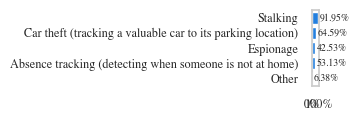

In [16]:
# Generate plots for all questions 
import plot_questions
import importlib
importlib.reload(plot_questions)

for question in results_percentages:
    answers = results_percentages[question]
    # Convert to dataframe 
    df_question = pd.DataFrame(columns=["answers", "count"])
    df_question["answers"] = answers.keys()
    df_question["count"] = answers.values()
    if len(answers.keys()) <= 20 and len(answers.keys()) > 1:
        print(f"Trying to plot {question}")
        plot_questions.plot_choice_question_horizontal(df_question, question, survey_set=survey_set)
        break

['Verdana', 'Helvetica', 'Athelas', 'PT Mono', 'Bodoni 72', 'Wingdings 3', 'Farah', 'Noto Sans Lydian', 'STIXGeneral', 'Malayalam Sangam MN', 'Hiragino Maru Gothic Pro', 'Impact', 'Noto Sans Modi', 'Bangla MN', 'Diwan Thuluth', 'Noto Sans Mro', 'Gill Sans', 'Mishafi', 'Noto Serif Myanmar', 'Noto Sans Thaana', 'Hiragino Sans GB', 'Noto Sans Elbasan', 'cmb10', 'Noto Sans Saurashtra', 'Noto Sans Limbu', 'Lucida Grande', 'cmsy10', 'Noto Sans Cypriot', 'PT Serif', 'Oriya Sangam MN', '.Aqua Kana', 'Noto Sans Brahmi', 'Palatino', 'Geneva', 'Myanmar Sangam MN', 'Muna', 'Noto Sans Pahawh Hmong', 'Rockwell', 'Noto Sans Myanmar', 'Webdings', 'Noto Sans Glagolitic', 'STIXSizeFourSym', 'Luminari', 'Noto Sans Palmyrene', 'Noto Sans Tai Tham', 'Noto Sans Old Italic', 'Noto Sans Coptic', 'AppleMyungjo', 'Brush Script MT', 'Monaco', 'cmss10', 'Roboto', 'Tamil Sangam MN', 'cmmi10', 'Futura', 'Noto Sans Meetei Mayek', 'Noto Sans Imperial Aramaic', '.New York', 'Noto Sans Hanifi Rohingya', 'Party LET', 'A

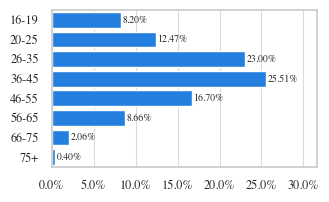

Trying to plot Please select your gender. 
Figsize: (3.3347170333471703, 1.25)
Saving figure to ../Results/Eval/Plots/Please_select_your_gender. _combined.pdf


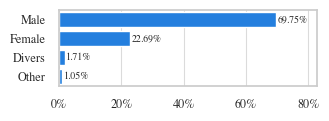

Trying to plot Please select in which region you are located
Figsize: (3.3347170333471703, 2.060968469471768)
Saving figure to ../Results/Eval/Plots/Please_select_in_which_region_you_are_located_combined.pdf


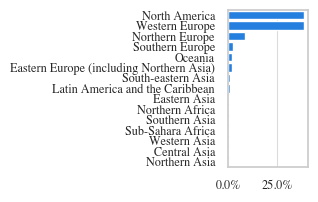

Trying to plot Which gender did your stalker have?
Figsize: (3.3347170333471703, 1.25)
Saving figure to ../Results/Eval/Plots/Which_gender_did_your_stalker_have_combined.pdf


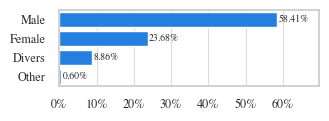

Trying to plot How long did the stalking continue?
Figsize: (3.3347170333471703, 1.0)
Saving figure to ../Results/Eval/Plots/How_long_did_the_stalking_continue_combined.pdf


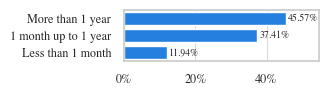

Trying to plot How often have you been pursued?
Figsize: (3.3347170333471703, 1.25)
Saving figure to ../Results/Eval/Plots/How_often_have_you_been_pursued_combined.pdf


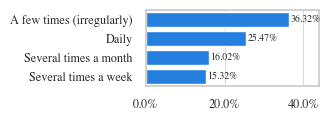

Trying to plot Have you been a victim to ongoing harassment?
Figsize: (3.3347170333471703, 0.75)
Saving figure to ../Results/Eval/Plots/Have_you_been_a_victim_to_ongoing_harassment_combined.pdf


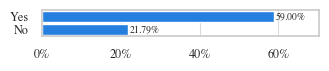

Trying to plot How is your current relation to the stalker?
Figsize: (3.3347170333471703, 2.060968469471768)
Saving figure to ../Results/Eval/Plots/How_is_your_current_relation_to_the_stalker_combined.pdf


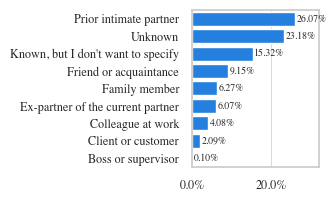

Trying to plot What do you think has been the motivation of the stalker?
Figsize: (3.3347170333471703, 1.75)
Saving figure to ../Results/Eval/Plots/What_do_you_think_has_been_the_motivation_of_the_stalker_combined.pdf


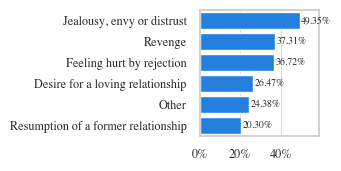

Trying to plot What methods of stalking have been used?
Figsize: (3.3347170333471703, 2.060968469471768)
Saving figure to ../Results/Eval/Plots/What_methods_of_stalking_have_been_used_combined.pdf


/Users/seemoo/Nextcloud/Research/AirGuard/Survey/Evaluation/plot_questions.py:212: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


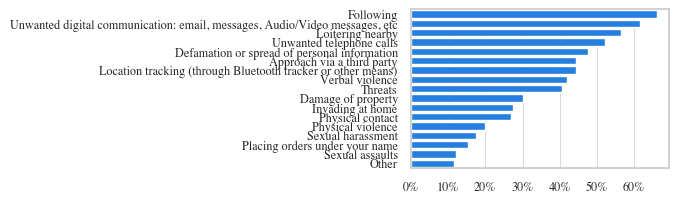

Trying to plot How has stalking impacted your life?
Figsize: (3.3347170333471703, 2.060968469471768)
Saving figure to ../Results/Eval/Plots/How_has_stalking_impacted_your_life_combined.pdf


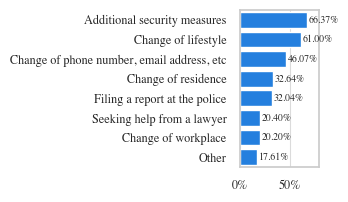

Trying to plot Where was the tracking device located?
Figsize: (3.3347170333471703, 1.5)
Saving figure to ../Results/Eval/Plots/Where_was_the_tracking_device_located_combined.pdf


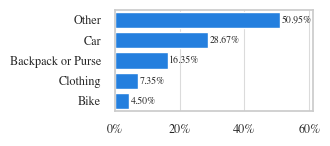

In [18]:
importlib.reload(plot_questions)
# Generate plots for demographic questions
questions = ["Please select the age group that matches your age. ", "Please select your gender. ", "Please select in which region you are located"]
questions += stalking_related_questions
questions  += ["Where was the tracking device located?"]

for question in questions:
    answers = results_percentages[question]
    # Convert to dataframe 
    df_question = pd.DataFrame(columns=["answers", "count"])
    df_question["answers"] = answers.keys()
    df_question["count"] = answers.values()
    if question == "Please select the age group that matches your age. ":
        # Order by age 
        df_question = df_question.sort_values(by=['answers'])
    else: 
        # Order by count 
        df_question = df_question.sort_values(by=['count'], ascending=False)
    
    if len(answers.keys()) <= 20 and len(answers.keys()) > 1:
        print(f"Trying to plot {question}")
        plot_questions.plot_choice_question_horizontal(df_question, question, survey_set=survey_set)

['Verdana', 'Helvetica', 'Athelas', 'PT Mono', 'Bodoni 72', 'Wingdings 3', 'Farah', 'Noto Sans Lydian', 'STIXGeneral', 'Malayalam Sangam MN', 'Hiragino Maru Gothic Pro', 'Impact', 'Noto Sans Modi', 'Bangla MN', 'Diwan Thuluth', 'Noto Sans Mro', 'Gill Sans', 'Mishafi', 'Noto Serif Myanmar', 'Noto Sans Thaana', 'Hiragino Sans GB', 'Noto Sans Elbasan', 'cmb10', 'Noto Sans Saurashtra', 'Noto Sans Limbu', 'Lucida Grande', 'cmsy10', 'Noto Sans Cypriot', 'PT Serif', 'Oriya Sangam MN', '.Aqua Kana', 'Noto Sans Brahmi', 'Palatino', 'Geneva', 'Myanmar Sangam MN', 'Muna', 'Noto Sans Pahawh Hmong', 'Rockwell', 'Noto Sans Myanmar', 'Webdings', 'Noto Sans Glagolitic', 'STIXSizeFourSym', 'Luminari', 'Noto Sans Palmyrene', 'Noto Sans Tai Tham', 'Noto Sans Old Italic', 'Noto Sans Coptic', 'AppleMyungjo', 'Brush Script MT', 'Monaco', 'cmss10', 'Roboto', 'Tamil Sangam MN', 'cmmi10', 'Futura', 'Noto Sans Meetei Mayek', 'Noto Sans Imperial Aramaic', '.New York', 'Noto Sans Hanifi Rohingya', 'Party LET', 'A

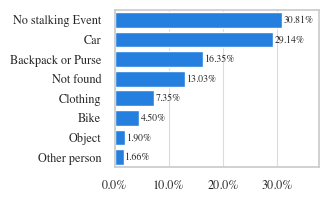

In [19]:
# tracker location
importlib.reload(plot_questions)
df_tracker_location = pd.read_csv("../Results/Eval/tracking_device_location_survey.csv")
plot_questions.plot_choice_question_horizontal(df_tracker_location, "tracking_device_location", survey_set=survey_set)

In [12]:
# # Generate a file with all open ended answers and all other answers

# # Filter out all questions that are not open ended
# results_open_ended = {} 
# for question in results: 
#     if results[question]["open_ended_answers"] is not None:
#         results_open_ended[question] = results[question]
#     elif results[question]["other_answers"] is not None:
#             results_open_ended[question] = results[question]

# # Create a dataframe for each open question with all answers 
# for question in results_open_ended: 
#     # Get the answers 
#     answers = results_open_ended[question]["other_answers"]
#     other = True
#     if answers == None: 
#         answers = results_open_ended[question]["open_ended_answers"]
#         other = False

#     # Convert to dataframe 
#     df_question = pd.DataFrame(columns=["question", "answers"])

#     if other:
#         given_answers = list(results_open_ended[question]["answer_counts"].keys())
#         df_question["question"] = [question] * (len(answers) + len(given_answers))
#         df_question["answers"] = given_answers + answers
#     else: 
#         df_question["question"] = [question] * (len(answers))
#         df_question["answers"] = answers

#     # Save the dataframe to a CSV 
#     question = question.replace(" ", "_")
#     question = question[:10]
#     df_question.to_csv(f"../Results/Eval/OpenQuestions/{question}_{survey_set}.csv")



In [13]:
control_variable_questions = ["Have you been a victim to stalking in general?","Are you a user of AirGuard or have you used AirGuard in the past?","How did you find out about our survey?"]

control_variable_columns = [] 
for q in control_variable_questions:
    columns = df_questions.columns.to_list()
    column_name = list(filter(lambda x: q in x, columns))[0]
    control_variable_columns.append(column_name)

dfs_to_code = []
excel_writer = pd.ExcelWriter(f'../Results/Eval/OpenQuestions/CodingQuestions_{survey_set}.xlsx', engine='auto')

i = 0
# Generate a dataframe for each open ended question 
other_columns = df_questions.columns[df_questions.columns.str.contains("Other")]
for column in other_columns: 
    # Get the df for the column
    columns = [column] + control_variable_columns
    df_column = df_questions[columns]
    # Remove all rows where the column is empty
    df_column = df_column[df_column[column].isna() == False]
    # Save the df to a CSV
    sheet_name = column.replace(" ", "_")
    sheet_name = sheet_name[:10]
    sheet_name = f"{i}_{sheet_name}"
    df_column.to_excel(excel_writer, sheet_name=sheet_name)
    i+=1

open_ended_questions = ["What are you missing in AirGuard?", "Do many incorrect notifications make you feel unsafe or anxious?Please explain your experience with incorrect notifications below. Like all questions, this is an optional question."]

for question in open_ended_questions: 
    # Get the df for the column 
    columns = [question] + control_variable_columns
    df_column = df_questions[columns]
    # Remove all rows where the column is empty 
    df_column = df_column[df_column[question].isna() == False]
    # Save the df to a CSV
    sheet_name = question.replace(" ", "_")
    sheet_name = sheet_name[:10]
    sheet_name = f"{i}_{sheet_name}"
    i+=1
    df_column.to_excel(excel_writer, sheet_name=sheet_name)

excel_writer.save()


/var/folders/dw/679j8kp90psgk8pxq06vmnzc0000gp/T/ipykernel_21451/1576679263.py:43: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  excel_writer.save()


['Minimum age declaration  [I hereby state that I am at least 16 years old]', 'Which potential misuse of key finders / Bluetooth trackers (e.g. AirTags) has been known to you before you started this survey? [Stalking]', 'Which potential misuse of key finders / Bluetooth trackers (e.g. AirTags) has been known to you before you started this survey? [Car theft (tracking a valuable car to its parking location)]', 'Which potential misuse of key finders / Bluetooth trackers (e.g. AirTags) has been known to you before you started this survey? [Espionage]', 'Which potential misuse of key finders / Bluetooth trackers (e.g. AirTags) has been known to you before you started this survey? [Absence tracking (detecting when someone is not at home)]', 'Which potential misuse of key finders / Bluetooth trackers (e.g. AirTags) has been known to you before you started this survey? [Other]', 'Do you agree with the statement:  "During the next 12 months, somebody will try to track me using a key finder" ',

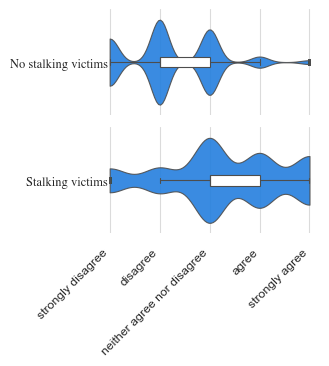

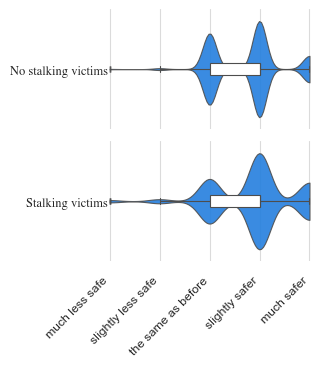

In [79]:
import violin_plot
importlib.reload(violin_plot)
# Analyze Do you agree with the statement:  “During the next 12 months, somebody will try to track me using a key finder”
def calculate_likert_value(df:pd.DataFrame, responses: list, question: str):
    # Calculate the likert value for each response
    likert_values = {}
    df_likert_values = pd.DataFrame(columns=["response", "count", "percentage", "likert_value", "likert_sum"])
    df_likert_responses = pd.DataFrame(columns=["response", "likert_value"])
    i = 1 

    total_count = 0
    for response in responses:
        count = (df[question] == response).value_counts()[True]
        total_count += count
        likert_values[response] = {
            "count": count,
            "percentage": count / len(df.index) * 100,
            "likert_value": i
        }
        likert_sum = i * count
        row = {"response": response, "count": count, "percentage": count / len(df.index) * 100, "likert_value": i, "likert_sum": likert_sum}
        df_likert_values.loc[i-1] = row
        likert_responses = {"response": [response] * count, "likert_value": [i] * count}
        df_likert_responses = pd.concat([df_likert_responses, pd.DataFrame.from_dict(likert_responses)])

        i+=1

    # Calculate the mean likert value
    mean_likert_value = df_likert_values["likert_sum"].sum() / total_count
    mean_likert_value_2 = df_likert_responses["likert_value"].mean()
    if mean_likert_value != mean_likert_value_2:
        print(f"Mean likert differs {mean_likert_value}, {mean_likert_value_2}")

    return mean_likert_value, df_likert_responses

columns = df_questions.columns.to_list()
print(columns)
question = df_questions.columns[df_questions.columns.str.contains("Do you agree with the statement")][0]

# question = "Do you agree with the statement:  \"During the next 12 months, somebody will try to track me using a key finder\""
responses = ["strongly disagree", "disagree", "neither agree nor disagree", "agree", "strongly agree"]
mean_likert, df_likert = calculate_likert_value(df_no_stalking_victims, responses, question)
print(f"Question = {question}, mean likert value = {mean_likert}")

print(f"Stalking victims {len(df_stalking_victims.index)}")
mean_likert, df_likert_stalking = calculate_likert_value(df_stalking_victims, responses, question)
print(f"Question = {question}, mean likert value = {mean_likert}")

violin_plot.plot_multiple_violin([df_likert, df_likert_stalking], "expected_stalking", ["response", "response"], ["No stalking victims", "Stalking victims"], out_dir="../Results/Eval/Plots/")

# Analyze Likert scale of Since I discovered AirGuard I feel ...
question = df_questions.columns[df_questions.columns.str.contains("Since I discovered AirGuard I feel")][0] 
responses = ["much less safe", "slightly less safe", "the same as before", "slightly more safe", "much more safe"]
mean_likert, df_likert = calculate_likert_value(df_no_stalking_victims, responses, question)
df_likert["response"] = df_likert["response"].replace("slightly more safe", "slightly safer")
df_likert["response"] = df_likert["response"].replace("much more safe", "much safer")
print(f"No stalking: Question = {question}, mean likert value = {mean_likert}")
mean_likert_stalking, df_likert_stalking = calculate_likert_value(df_stalking_victims, responses, question)
df_likert_stalking["response"] = df_likert_stalking["response"].replace("slightly more safe", "slightly safer")
df_likert_stalking["response"] = df_likert_stalking["response"].replace("much more safe", "much safer")
print(f"Stalking: Question = {question}, mean likert value = {mean_likert_stalking}")

violin_plot.plot_multiple_violin([df_likert, df_likert_stalking], "feeling", ["response", "response"], ["No stalking victims", "Stalking victims"], out_dir="../Results/Eval/Plots/")

mean_likert, df_likert = calculate_likert_value(df_finished, responses, question)
print(f"All: Question = {question}, mean likert value = {mean_likert}")

['Noto Sans Imperial Aramaic', 'STIXIntegralsUpD', 'cmss10', 'Andale Mono', 'System Font', 'Apple Chancery', 'Malayalam MN', 'Bodoni 72 Oldstyle', 'Roboto', 'Bradley Hand', 'Noto Sans Limbu', 'Hiragino Sans GB', 'Noto Sans Tirhuta', '.SF Compact', 'Geneva', 'Noto Sans Lisu', 'Songti SC', 'Georgia', 'Noto Sans Caucasian Albanian', 'Noto Serif Yezidi', 'Noto Sans Rejang', 'Khmer Sangam MN', 'Telugu Sangam MN', 'Noto Sans Armenian', 'Bangla MN', 'Noto Sans PhagsPa', 'Kokonor', 'Palatino', 'Noto Sans Khojki', 'Mishafi', 'Mshtakan', '.SF Compact Rounded', 'Noto Sans Manichaean', 'Noto Sans Warang Citi', 'Noto Sans Linear B', 'Big Caslon', 'Noto Sans Kannada', 'Hiragino Mincho ProN', 'Noto Sans NKo', 'Noto Sans Sundanese', 'Noto Sans Kharoshthi', 'Noto Sans Samaritan', '.Keyboard', 'Noto Serif Balinese', 'Noto Sans Mende Kikakui', 'Optima', 'Zapfino', 'Noto Sans Duployan', 'Lucida Grande', 'Telugu MN', 'Baghdad', 'Chalkduster', 'Kohinoor Devanagari', 'Avenir Next', 'Snell Roundhand', 'DecoTy

,response,stalking,likert_value,count,percentage
0,Much less safe,0,1,7,0.174173
2,Slightly less safe,0,2,34,0.845982
4,The same\nas before,0,3,1308,32.545409
3,Slightly safer,0,4,1762,43.841752
1,Much safer,0,5,485,12.067679
0,Much less safe,1,1,9,0.895522
2,Slightly less safe,1,2,16,1.592040
4,The same\nas before,1,3,173,17.213930
3,Slightly safer,1,4,372,37.014925
1,Much safer,1,5,144,14.328358


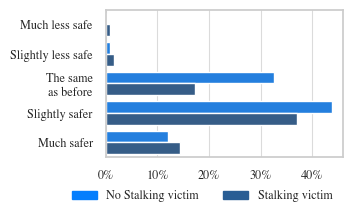

In [197]:
# Likert bar chart 
importlib.reload(plot_questions)

# Analyze Likert scale of Since I discovered AirGuard I feel ...
question = df_questions.columns[df_questions.columns.str.contains("Since I discovered AirGuard I feel")][0] 
responses = ["much less safe", "slightly less safe", "the same as before", "slightly more safe", "much more safe"]
mean_likert, df_likert = calculate_likert_value(df_no_stalking_victims, responses, question)
df_likert["response"] = df_likert["response"].replace("slightly more safe", "slightly safer")
df_likert["response"] = df_likert["response"].replace("much more safe", "much safer")
df_likert["stalking"] = 0 
df_likert["count"] = 0
df_likert = df_likert.groupby(["response", "stalking", "likert_value"]).count().reset_index() 
df_likert["percentage"] = df_likert["count"] / len(df_no_stalking_victims.index) * 100
df_likert["response"] = df_likert["response"].replace("the same as before", "the same\nas before")
df_likert["response"] = df_likert["response"].str.capitalize()
print(f"No stalking: Question = {question}, mean likert value = {mean_likert}")


mean_likert_stalking, df_likert_stalking = calculate_likert_value(df_stalking_victims, responses, question)
df_likert_stalking["response"] = df_likert_stalking["response"].replace("slightly more safe", "slightly safer")
df_likert_stalking["response"] = df_likert_stalking["response"].replace("much more safe", "much safer")
df_likert_stalking["stalking"] = 1
df_likert_stalking["count"] = 0
df_likert_stalking = df_likert_stalking.groupby(["response", "stalking", "likert_value"]).count().reset_index() 
df_likert_stalking["percentage"] = df_likert_stalking["count"] / len(df_stalking_victims.index) * 100
df_likert_stalking["response"] = df_likert_stalking["response"].replace("the same as before", "the same\nas before")
df_likert_stalking["response"] = df_likert_stalking["response"].str.capitalize()
print(f"Stalking: Question = {question}, mean likert value = {mean_likert_stalking}")


df_likert_combined = pd.concat([df_likert, df_likert_stalking], ignore_index=False)
df_likert_combined = df_likert_combined.sort_values(by=["stalking", "likert_value"])
display(df_likert_combined)

# Bar plot 
fig, ax = plt.subplots(figsize=plot_questions.set_size(241))
sns.barplot(data=df_likert_combined, y="response", x="percentage", hue="stalking", orient="h", palette=plot_questions.color_palette, legend=False , ax=ax)

# Create legend on the bottom right 
mpatches = mpl.patches
top_bar = mpatches.Patch(color=plot_questions.color_palette[0], label='No Stalking victim')
bottom_bar = mpatches.Patch(color=plot_questions.color_palette[1], label='Stalking victim')
# plt.legend(handles=[top_bar, bottom_bar], loc="lower left")
#Move legend outside of plot
plt.legend( bbox_to_anchor=(1.0, -0.15), ncol=2, handles=[top_bar, bottom_bar], frameon=False)
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

ax.set_ylabel(None)
ax.set_xlabel(None)
ax.set_xticks([0,10,20,30,40])
ax.xaxis.set_major_formatter(mpl.ticker.PercentFormatter(decimals=0))

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
plt.tight_layout(pad=0)
plt.savefig("../Results/Eval/Plots/likert_scale_safety.pdf", bbox_inches="tight")    
plt.show()
plt.close()

# Stacked bar char 
# sns.barplot(data=df_likert_combined, y="stalking", x="percentage", hue="response", orient="h", dodge=False, legend=False)
# df_plot = df_likert_combined
# df_plot.drop(columns=["count", "likert_value"], inplace=True)
# df_plot.index = df_plot["response"]
# df_plot = pd.concat([df_plot[df_plot["stalking"] == 0], df_plot[df_plot["stalking"] == 1]], axis=1)
# df_plot.plot(kind="barh", stacked=True, legend=True, color=["red", "blue", "green", "yellow", "orange"])

# Create one dataframe for each response 

# sns.barplot(data=df_likert_combined[df_likert_combined["response"] == "strongly disagree"], y="stalking", x="percentage", orient="h", color="red")
# sns.barplot(data=df_likert_combined[df_likert_combined["response"] == "disagree"], y="stalking", x="percentage", orient="h", estimator=sum, color="yellow")
# sns.barplot(data=df_likert_combined[df_likert_combined["response"] == "neither agree nor disagree"], y="stalking", x="percentage", orient="h", estimator=sum, color="gray")
# sns.barplot(data=df_likert_combined[df_likert_combined["response"] == "agree"], y="stalking", x="percentage", orient="h", estimator=sum, color="green")
# sns.barplot(data=df_likert_combined[df_likert_combined["response"] == "strongly agree"], y="stalking", x="percentage", orient="h", estimator=sum, color="blue")


['Noto Sans Imperial Aramaic', 'STIXIntegralsUpD', 'cmss10', 'Andale Mono', 'System Font', 'Apple Chancery', 'Malayalam MN', 'Bodoni 72 Oldstyle', 'Roboto', 'Bradley Hand', 'Noto Sans Limbu', 'Hiragino Sans GB', 'Noto Sans Tirhuta', '.SF Compact', 'Geneva', 'Noto Sans Lisu', 'Songti SC', 'Georgia', 'Noto Sans Caucasian Albanian', 'Noto Serif Yezidi', 'Noto Sans Rejang', 'Khmer Sangam MN', 'Telugu Sangam MN', 'Noto Sans Armenian', 'Bangla MN', 'Noto Sans PhagsPa', 'Kokonor', 'Palatino', 'Noto Sans Khojki', 'Mishafi', 'Mshtakan', '.SF Compact Rounded', 'Noto Sans Manichaean', 'Noto Sans Warang Citi', 'Noto Sans Linear B', 'Big Caslon', 'Noto Sans Kannada', 'Hiragino Mincho ProN', 'Noto Sans NKo', 'Noto Sans Sundanese', 'Noto Sans Kharoshthi', 'Noto Sans Samaritan', '.Keyboard', 'Noto Serif Balinese', 'Noto Sans Mende Kikakui', 'Optima', 'Zapfino', 'Noto Sans Duployan', 'Lucida Grande', 'Telugu MN', 'Baghdad', 'Chalkduster', 'Kohinoor Devanagari', 'Avenir Next', 'Snell Roundhand', 'DecoTy

,response,stalking,likert_value,count,percentage
4,Strongly disagree,0,1,871,21.672058
1,Disagree,0,2,1569,39.039562
2,Neither agree\n nor disagree,0,3,1211,30.131874
0,Agree,0,4,207,5.150535
3,Strongly agree,0,5,71,1.766609


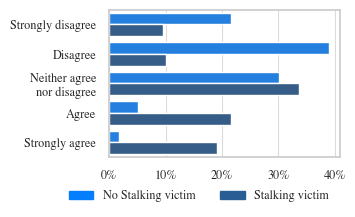

In [191]:
# Likert bar chart 
importlib.reload(plot_questions)
#"Do you agree with the statement:  \"During the next 12 months, somebody will try to track me using a key finder\""
question = df_questions.columns[df_questions.columns.str.contains("Do you agree with the statement")][0]
responses = ["strongly disagree", "disagree", "neither agree nor disagree", "agree", "strongly agree"]
mean_likert, df_likert = calculate_likert_value(df_no_stalking_victims, responses, question)
df_likert["stalking"] = 0 
df_likert["count"] = 0
df_likert = df_likert.groupby(["response", "stalking", "likert_value"]).count().reset_index() 
df_likert["percentage"] = df_likert["count"] / len(df_no_stalking_victims.index) * 100
df_likert["response"] = df_likert["response"].replace("neither agree nor disagree", "neither agree\n nor disagree")
df_likert["response"] = df_likert["response"].str.capitalize()
print(f"Question = {question}, mean likert value = {mean_likert}")

print(f"Stalking victims {len(df_stalking_victims.index)}")
mean_likert, df_likert_stalking = calculate_likert_value(df_stalking_victims, responses, question)
df_likert_stalking["stalking"] = 1
df_likert_stalking["count"] = 0
df_likert_stalking = df_likert_stalking.groupby(["response", "stalking", "likert_value"]).count().reset_index() 
df_likert_stalking["percentage"] = df_likert_stalking["count"] / len(df_stalking_victims.index) * 100
df_likert_stalking["response"] = df_likert_stalking["response"].replace("neither agree nor disagree", "neither agree\n nor disagree")
df_likert_stalking["response"] = df_likert_stalking["response"].str.capitalize()
print(f"Question = {question}, mean likert value = {mean_likert}")

df_likert_combined = pd.concat([df_likert, df_likert_stalking], ignore_index=False)
df_likert_combined = df_likert_combined.sort_values(by=["stalking", "likert_value"])
display(df_likert_combined.head())

# Bar plot 
fig, ax = plt.subplots(figsize=plot_questions.set_size(241))
sns.barplot(data=df_likert_combined, y="response", x="percentage", hue="stalking", orient="h", palette=plot_questions.color_palette, legend=False , ax=ax)

# Create legend on the bottom right 
mpatches = mpl.patches
top_bar = mpatches.Patch(color=plot_questions.color_palette[0], label='No Stalking victim')
bottom_bar = mpatches.Patch(color=plot_questions.color_palette[1], label='Stalking victim')
# plt.legend(handles=[top_bar, bottom_bar], loc="lower left")
#Move legend outside of plot
plt.legend( bbox_to_anchor=(1.0, -0.15), ncol=2, handles=[top_bar, bottom_bar], frameon=False)
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

ax.set_ylabel(None)
ax.set_xlabel(None)
ax.set_xticks([0,10,20,30,40])
ax.xaxis.set_major_formatter(mpl.ticker.PercentFormatter(decimals=0))

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
plt.tight_layout(pad=0)
plt.savefig("../Results/Eval/Plots/likert_scale_stalking_expected.pdf", bbox_inches="tight")    
plt.show()
plt.close()

# Stacked bar char 
# sns.barplot(data=df_likert_combined, y="stalking", x="percentage", hue="response", orient="h", dodge=False, legend=False)
# df_plot = df_likert_combined
# df_plot.drop(columns=["count", "likert_value"], inplace=True)
# df_plot.index = df_plot["response"]
# df_plot = pd.concat([df_plot[df_plot["stalking"] == 0], df_plot[df_plot["stalking"] == 1]], axis=1)
# df_plot.plot(kind="barh", stacked=True, legend=True, color=["red", "blue", "green", "yellow", "orange"])

# Create one dataframe for each response 

# sns.barplot(data=df_likert_combined[df_likert_combined["response"] == "strongly disagree"], y="stalking", x="percentage", orient="h", color="red")
# sns.barplot(data=df_likert_combined[df_likert_combined["response"] == "disagree"], y="stalking", x="percentage", orient="h", estimator=sum, color="yellow")
# sns.barplot(data=df_likert_combined[df_likert_combined["response"] == "neither agree nor disagree"], y="stalking", x="percentage", orient="h", estimator=sum, color="gray")
# sns.barplot(data=df_likert_combined[df_likert_combined["response"] == "agree"], y="stalking", x="percentage", orient="h", estimator=sum, color="green")
# sns.barplot(data=df_likert_combined[df_likert_combined["response"] == "strongly agree"], y="stalking", x="percentage", orient="h", estimator=sum, color="blue")


In [179]:
# Deeper analysis of stalking related questions 
print(stalking_related_questions)

def get_stats_single_choice(df: pd.DataFrame, question: str, responses: list):
    stats = {}
    for response in responses:
        if response == "Other":
            # Get the other responses 
            response_count = df[question + " [Other]"].dropna().count()
        else: 
            response_count = df[question].value_counts()[response]
        response_percentage = response_count / len(df.index) * 100
        stats[response] = {"count": response_count, "percentage": response_percentage}

    return stats    

print("Overall stalking victims: ", len(df_stalking_victims.index))

gender_stalking_stats = get_stats_single_choice(df_stalking_victims, question="Please select your gender.\u00a0", responses=["Male", "Female", "Divers", "Other"])
print("Gender of stalking victims stats:\n ", gender_stalking_stats)

gender_stalker_stalking_stats = get_stats_single_choice(df_stalking_victims, question="Which gender did your stalker have?", responses=["Male", "Female", "Divers", "Other"])
print("Gender of stalkers stats:\n ", gender_stalker_stalking_stats)

# Match gender of the respondent with gender of the stalker
df_male_stalking_victims = df_stalking_victims[ df_stalking_victims["Please select your gender.\u00a0"] == "Male"]
# Calculate the percentage on genders of the stalker 
male_stats = get_stats_single_choice(df=df_male_stalking_victims, question="Which gender did your stalker have?", responses=["Male", "Female", "Divers", "Other"])
print("Male victims stats:\n", male_stats)

df_female_stalking_victims = df_stalking_victims[ df_stalking_victims["Please select your gender.\u00a0"] == "Female"]
# Calculate the percentage on genders of the stalker 
female_stats = get_stats_single_choice(df=df_female_stalking_victims, question="Which gender did your stalker have?", responses=["Male", "Female", "Divers", "Other"])
print("Female victims stats:\n", female_stats)


df_divers_stalking_victims = df_stalking_victims[ df_stalking_victims["Please select your gender.\u00a0"] == "Divers"]
# Calculate the percentage on genders of the stalker 
divers_stats = get_stats_single_choice(df=df_divers_stalking_victims, question="Which gender did your stalker have?", responses=["Male", "Female", "Divers", "Other"])
print("Divers victims stats:\n", divers_stats)

df_other_stalking_victims = df_stalking_victims[ df_stalking_victims["Please select your gender.\u00a0"] == "Other"]
# Calculate the percentage on genders of the stalker 
other_stats = get_stats_single_choice(df=df_other_stalking_victims, question="Which gender did your stalker have?", responses=["Male", "Female", "Divers", "Other"])
print("Other victims stats:\n", other_stats)




['Which gender did your stalker have?', 'How long did the stalking continue?', 'How often have you been pursued?', 'Have you been a victim to ongoing harassment?', 'How is your current relation to the stalker?', 'What do you think has been the motivation of the stalker?', 'What methods of stalking have been used?', 'How has stalking impacted your life?']
Overall stalking victims:  1005
Gender of stalking victims stats:
  {'Male': {'count': 417, 'percentage': 41.492537313432834}, 'Female': {'count': 490, 'percentage': 48.756218905472636}, 'Divers': {'count': 24, 'percentage': 2.3880597014925375}, 'Other': {'count': 17, 'percentage': 1.691542288557214}}
Gender of stalkers stats:
  {'Male': {'count': 587, 'percentage': 58.40796019900497}, 'Female': {'count': 238, 'percentage': 23.681592039800993}, 'Divers': {'count': 89, 'percentage': 8.855721393034825}, 'Other': {'count': 6, 'percentage': 0.5970149253731344}}
Male victims stats:
 {'Male': {'count': 141, 'percentage': 33.81294964028777}, 

In [59]:
# Methods of stalking used. 

# We want to evaluate how many different methods of stalking have been used. 

stalking_methods = results["What methods of stalking have been used?"]["answer_counts"].keys()
stalking_methods = df_stalking_victims.columns.to_list()
stalking_methods = list(filter(lambda x: "What methods of stalking have been used?" in x, stalking_methods))
print("Stalking methods: ", stalking_methods)
print("Staling methods count: ", len(stalking_methods))
# stalking_methods = list([ f"What methods of stalking have been used? [{x}]" for x in stalking_methods])
df_stalking_methods = df_stalking_victims[stalking_methods]

# Count the stalking methods used per victim
method_count = (df_stalking_methods[stalking_methods] == "Yes").sum(axis=1)
df_stalking_methods["method_count"] = method_count

print(f"Mean number of stalking methods {df_stalking_methods['method_count'].mean()}")

# Count the frequency of each unique count of "Yes"
frequency_counts = method_count.value_counts().sort_index()

# Calculate the percentage of each count
percentage_counts = method_count.value_counts(normalize=True).sort_index() * 100

# You can combine these into a single DataFrame for a clearer overview
summary_df = pd.DataFrame({
    'Frequency': frequency_counts, 
    'Percentage': percentage_counts
})

# Display the summary DataFrame
print(summary_df)

Stalking methods:  ['What methods of stalking have been used?\xa0 [Unwanted telephone calls]', 'What methods of stalking have been used?\xa0 [Loitering nearby]', 'What methods of stalking have been used?\xa0 [Unwanted digital communication: email, messages, Audio/Video messages, etc]', 'What methods of stalking have been used?\xa0 [Location tracking (through Bluetooth tracker or other means)]', 'What methods of stalking have been used?\xa0 [Following]', 'What methods of stalking have been used?\xa0 [Approach via a third party]', 'What methods of stalking have been used?\xa0 [Damage of property]', 'What methods of stalking have been used?\xa0 [Invading at home]', 'What methods of stalking have been used?\xa0 [Placing orders under your name]', 'What methods of stalking have been used?\xa0 [Defamation or spread of personal information]', 'What methods of stalking have been used?\xa0 [Threats]', 'What methods of stalking have been used?\xa0 [Physical contact]', 'What methods of stalking ha

/var/folders/dw/679j8kp90psgk8pxq06vmnzc0000gp/T/ipykernel_21451/1679032426.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stalking_methods["method_count"] = method_count


In [17]:
# Impact on people's life 
impact_question = "How has stalking impacted your life?"

impact_answers = df_stalking_victims.columns.to_list()
impact_answers = list(filter(lambda x:impact_question in x, impact_answers))
print("Impact: ", impact_answers)
print("Impact count: ", len(impact_answers))
# stalking_methods = list([ f"What methods of stalking have been used? [{x}]" for x in stalking_methods])
df_impact = df_stalking_victims[impact_answers]

# Count the stalking methods used per victim
impact_count = (df_impact[impact_answers] == "Yes").sum(axis=1)
df_impact["impact_count"] = impact_count

print(f"Mean number impact {df_impact['impact_count'].mean()}")

# Count the frequency of each unique count of "Yes"
frequency_counts = impact_count.value_counts().sort_index()

# Calculate the percentage of each count
percentage_counts = impact_count.value_counts(normalize=True).sort_index() * 100

# You can combine these into a single DataFrame for a clearer overview
summary_df = pd.DataFrame({
    'Frequency': frequency_counts, 
    'Percentage': percentage_counts
})

# Display the summary DataFrame
print(summary_df)

Impact:  ['How has stalking impacted your life?  [Change of lifestyle]', 'How has stalking impacted your life?  [Change of phone number, email address, etc ]', 'How has stalking impacted your life?  [Additional security measures]', 'How has stalking impacted your life?  [Change of residence]', 'How has stalking impacted your life?  [Change of workplace]', 'How has stalking impacted your life?  [Seeking help from a lawyer]', 'How has stalking impacted your life?  [Filing a report at the police]', 'How has stalking impacted your life?  [Other]']
Impact count:  8
Mean number impact 2.7870646766169154
   Frequency  Percentage
0         85    8.457711
1        218   21.691542
2        192   19.104478
3        180   17.910448
4        128   12.736318
5        106   10.547264
6         55    5.472637
7         41    4.079602


/var/folders/dw/679j8kp90psgk8pxq06vmnzc0000gp/T/ipykernel_21451/3062057310.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_impact["impact_count"] = impact_count
